# Loading the necesary packages


In [2]:
import os
import glob
import time
import sys

# Libraries for data manipulation
import pandas as pd
from PIL import Image
import numpy as np

# Libraries for image processing
import cv2
from skimage.transform import resize
from skimage import io
import albumentations as A  # For data augmentation

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Libraries for saving/loading serialized Python objects
import pickle

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Helper functions
import helpers

# Set paths

In [3]:
# Set paths
dataset_path = '/Users/q/Documents/vub-ml-project-2024-animal-classification'
output_path = '/Users/q/Documents/vub-ml-project-2024-animal-classification/FirstModel'

dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')
features_path_train = os.path.join(output_path, 'features', 'train')
features_path_test = os.path.join(output_path, 'features', 'test')
prediction_path = os.path.join(output_path, 'predictions')

# Create paths if they don't exist
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)


Before starting to train the data, we do some analyis. From the plotbeneath we can see that there is a serious class imbalance.
WTaking class imbalance into account will be a priority, as our chosen classifier is sensitive to class imbalance.  

see (https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/#h-why-is-it-essential-to-deal-with-class-imbalance)

# Create dataframe with necesarry information for training data

In [4]:
# Gather information about each image
images_info = []
for root, dirs, files in os.walk(dataset_path_train):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(root, file)
            label = os.path.basename(root)
            with Image.open(filepath) as img:
                width, height = img.size
                aspect_ratio = width / height
                images_info.append({
                    'filename': file, 'image_path': filepath,
                    'label': label, 'width': width, 'height': height, 'aspect_ratio': aspect_ratio
                })

# Create DataFrame for image information
images_df = pd.DataFrame(images_info)
print(images_df.head())

       filename                                         image_path label  \
0  fox_0032.jpg  /Users/q/Documents/vub-ml-project-2024-animal-...   fox   
1  fox_0026.jpg  /Users/q/Documents/vub-ml-project-2024-animal-...   fox   
2  fox_0218.jpg  /Users/q/Documents/vub-ml-project-2024-animal-...   fox   
3  fox_0230.jpg  /Users/q/Documents/vub-ml-project-2024-animal-...   fox   
4  fox_0224.jpg  /Users/q/Documents/vub-ml-project-2024-animal-...   fox   

   width  height  aspect_ratio  
0    300     168      1.785714  
1   1080     810      1.333333  
2   1080     771      1.400778  
3   1080     720      1.500000  
4   1080    1350      0.800000  


# Check class distribution
Analysis of class distribution tells there is a class imbalance.

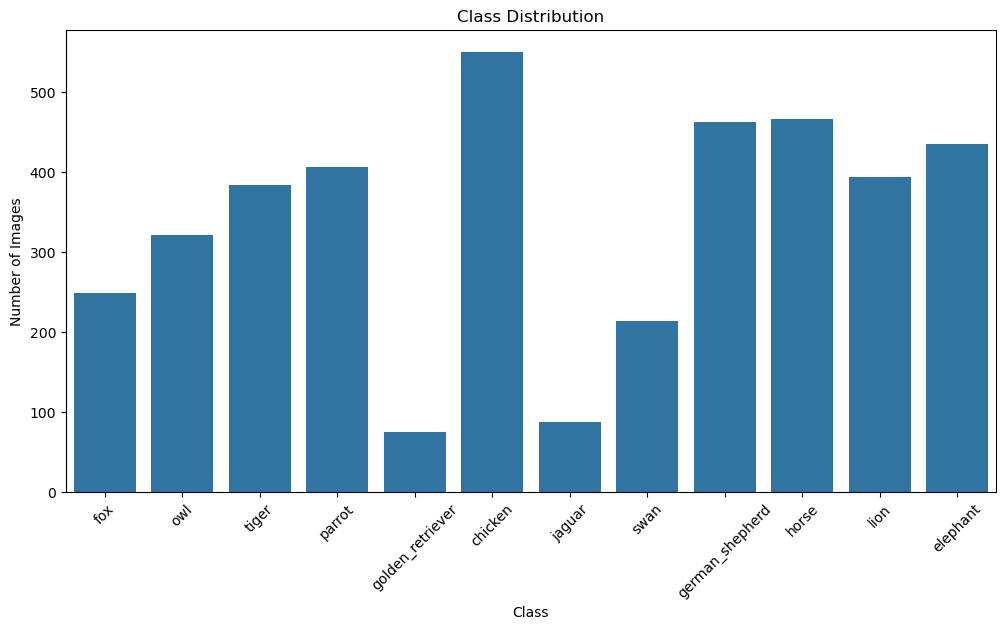

In [5]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=images_df)
plt.xticks(rotation=45)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [6]:
print(len(images_df))

4042


# Size analysis
When comparing size we see that there is a size imbalance as well, which will be solved by resizing the samples. This wil be part of the preprocessing for the model(Meaning it will be implemented for training validation and test data, as well as when new data is fed into the pipeline, this will happen)

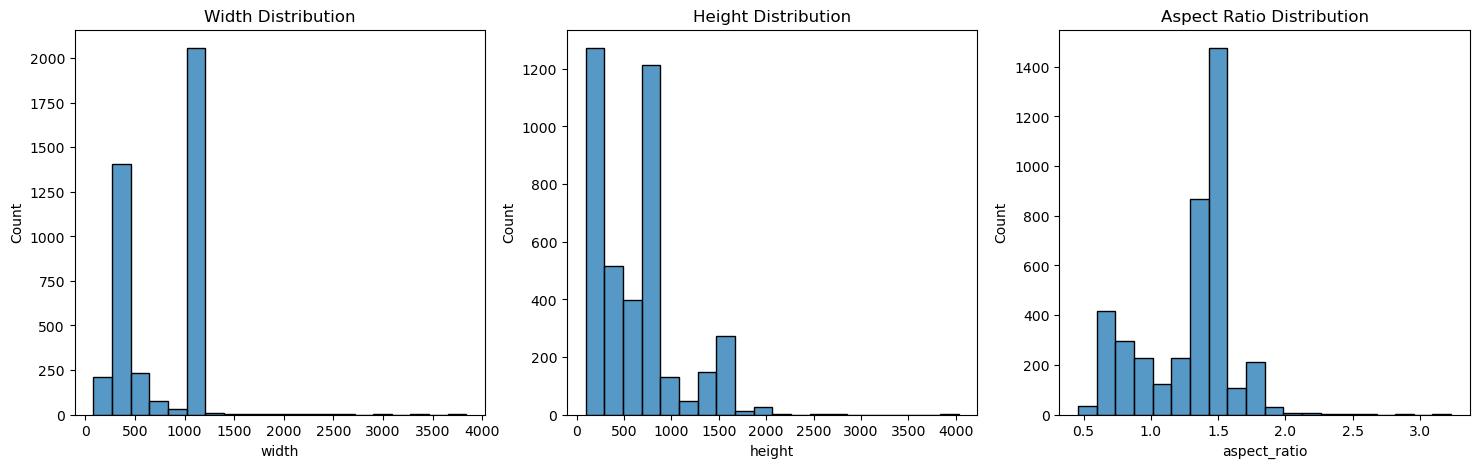

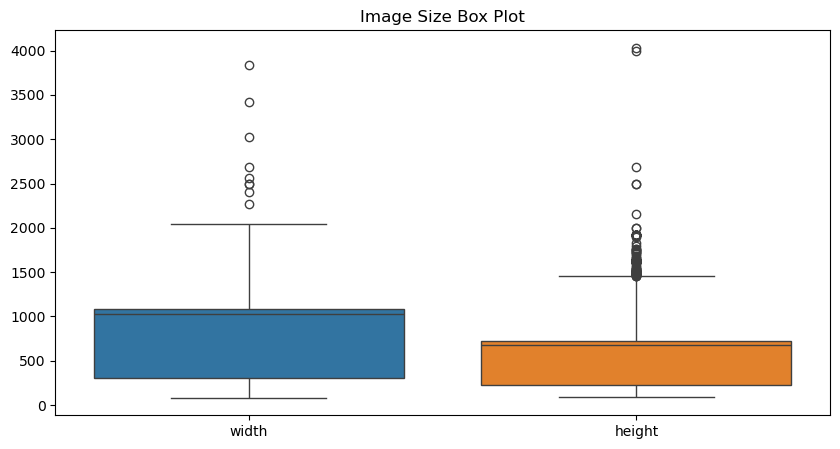

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Width Distribution
sns.histplot(images_df['width'], ax=axes[0], bins=20)
axes[0].set_title('Width Distribution')

# Height Distribution
sns.histplot(images_df['height'], ax=axes[1], bins=20)
axes[1].set_title('Height Distribution')

# Aspect Ratio Distribution
sns.histplot(images_df['aspect_ratio'], ax=axes[2], bins=20)
axes[2].set_title('Aspect Ratio Distribution')

plt.show()

# Box plot for width and height
plt.figure(figsize=(10, 5))
sns.boxplot(data=images_df[['width', 'height']])
plt.title('Image Size Box Plot')
plt.show()


# Color analysis
We check check for RGB inbalance

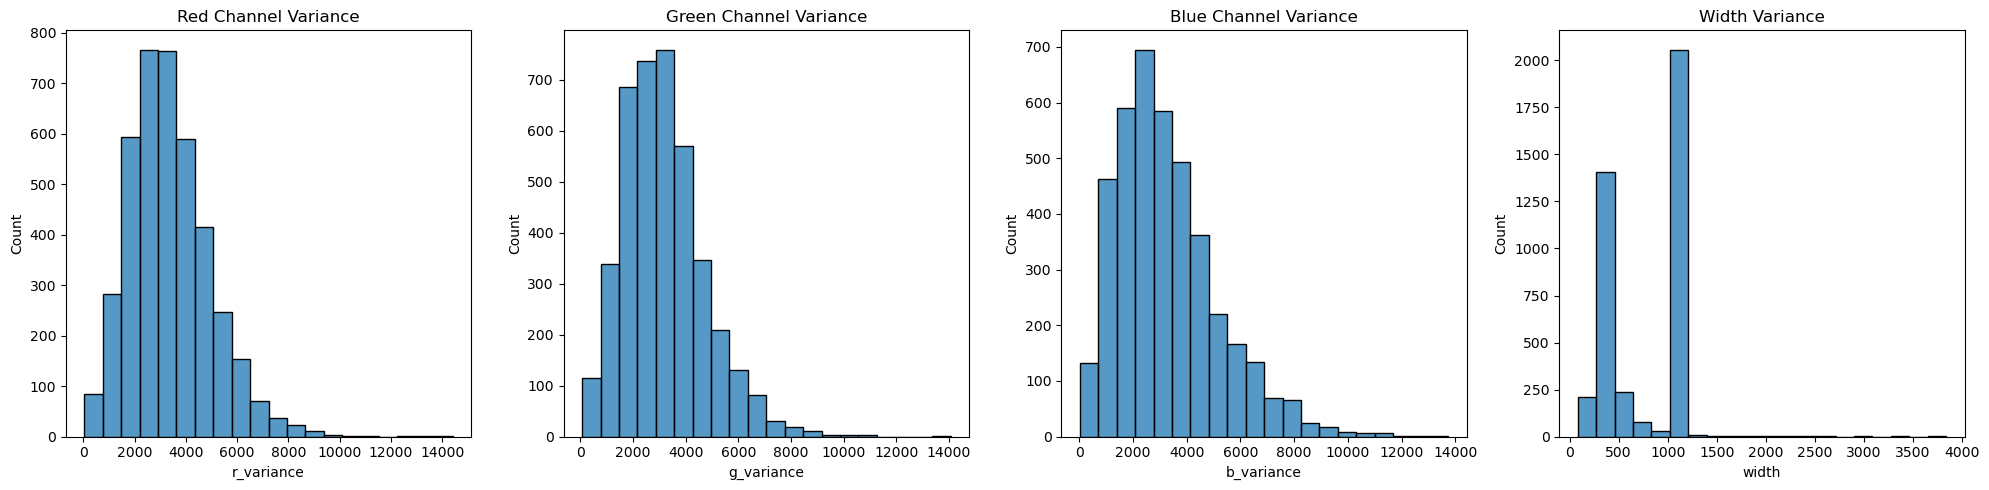

In [8]:
# Calculate R, G, B, and Width variance for each image
rgb_variances = []
for _, row in images_df.iterrows():
    filepath = row['image_path']
    with Image.open(filepath) as img:
        img_array = np.array(img)
        
        # Check if image has color channels (3-dimensional array)
        if len(img_array.shape) == 3:
            r_var = np.var(img_array[:, :, 0])
            g_var = np.var(img_array[:, :, 1])
            b_var = np.var(img_array[:, :, 2])
        else:
            r_var = g_var = b_var = 0  # For grayscale images

        # Append variances along with width for analysis
        rgb_variances.append({
            'filename': row['filename'],
            'label': row['label'],
            'r_variance': r_var,
            'g_variance': g_var,
            'b_variance': b_var,
            'width': row['width']
        })

# Create DataFrame from variance information
rgb_var_df = pd.DataFrame(rgb_variances)

# Plot R, G, B, and Width variance distributions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.histplot(rgb_var_df['r_variance'], ax=axes[0], bins=20)
axes[0].set_title('Red Channel Variance')

sns.histplot(rgb_var_df['g_variance'], ax=axes[1], bins=20)
axes[1].set_title('Green Channel Variance')

sns.histplot(rgb_var_df['b_variance'], ax=axes[2], bins=20)
axes[2].set_title('Blue Channel Variance')

sns.histplot(rgb_var_df['width'], ax=axes[3], bins=20)
axes[3].set_title('Width Variance')

plt.tight_layout()
plt.show()


# Split dataset
we split the dataframe into train and validation data. (20% validation)

In [13]:
# Split the original dataset into train and test sets
train_df, test_df = train_test_split(images_df, test_size=0.3, stratify=images_df['label'], random_state=42)

# Further split the train set into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.3, stratify=train_df['label'], random_state=42)

# Get class distributions
train_dist = train_df['label'].value_counts().rename('Train')
val_dist = val_df['label'].value_counts().rename('Validation')
test_dist = test_df['label'].value_counts().rename('Test')

# Separate features and labels
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

# Concatenate distributions into a single DataFrame
class_distributions = pd.concat([train_dist, val_dist, test_dist], axis=1)

# Display class distributions
print(class_distributions)

                  Train  Validation  Test
label                                    
chicken             269         116   165
horse               228          98   140
german_shepherd     226          97   139
elephant            213          91   131
parrot              199          85   122
lion                193          83   118
tiger               188          80   115
owl                 157          68    96
fox                 122          52    75
swan                105          45    64
jaguar               43          18    26
golden_retriever     37          16    22


# Data preprocessing

The data preprocessing will be equal for train, validation and test data. This ensures consistency for our model. Since the Mulit Layer Perceptron classifier is sensitive to noise and class imbalance. Resizing the images would be preferable.

In [10]:
# Define target size for resizing
target_size = (249, 249)  # You can adjust these values as needed



# Function to resize images and handle missing files
def resize_image(df, target_size):
    missing_files = []
    for i, row in df.iterrows():
        filepath = row['image_path']
        if os.path.exists(filepath):
            img_array = io.imread(filepath)
            resized_img = resize(img_array, target_size, anti_aliasing=True)
            df.at[i, 'width'] = resized_img.shape[1]
            df.at[i, 'height'] = resized_img.shape[0]
            df.at[i, 'aspect_ratio'] = resized_img.shape[1] / resized_img.shape[0]
        else:
            missing_files.append(filepath)
    # Log missing files
    if missing_files:
        print(f"Missing files: {missing_files}")
    # Remove rows with missing files
    return df[~df['image_path'].isin(missing_files)]

# Resize training images
train_df = resize_image(train_df, target_size)

# Resize validation images
val_df = resize_image(val_df, target_size)

test_df = resize_image(test_df, target_size)

# Definition feature extract function
started with 500 keypoint, low train and validation accuracy.
700 keypoints :

In [11]:
from skimage.feature import ORB
import numpy as np

def extract_orb_features_per_image(image_paths, labeled=True):
    descriptors = []
    labels = []
    
    orb_extractor = ORB(n_keypoints=700)  # Adjust the number of keypoints as needed
    
    for item in image_paths:
        if labeled:
            label, image_path = item
        else:
            image_path = item
        
        img_array = io.imread(image_path, as_gray=True)  # Load image in grayscale for ORB
        orb_extractor.detect_and_extract(img_array)
        
        # Check if descriptors are found
        if orb_extractor.descriptors is not None and len(orb_extractor.descriptors) > 0:
            # Average the descriptors for the current image
            avg_descriptor = np.mean(orb_extractor.descriptors, axis=0)
            descriptors.append(avg_descriptor)
            
            # Append label only if labeled data is provided
            if labeled:
                labels.append(label)
    
    if labeled:
        return np.array(descriptors), np.array(labels)
    else:
        return np.array(descriptors)



# Definition of the encode features function

In [12]:
def encode_features(descriptors, kmeans):
    # Ensure descriptors is 2D
    if descriptors.ndim == 1:
        descriptors = descriptors.reshape(1, -1)  # Reshape to 2D if it's a single descriptor
    
    # Predict the closest cluster for each descriptor
    cluster_indices = kmeans.predict(descriptors)
    
    # Create a histogram of visual words
    histogram = np.zeros(kmeans.n_clusters)
    for index in cluster_indices:
        histogram[index] += 1
    
    return histogram


# Feature extraction

In [ ]:
# Ensure y_test_encoded is defined before use
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Feature extraction (ORB features)
filtered_image_paths_train = [(row['label'], row['image_path']) for _, row in train_df.iterrows()]
train_descriptors, y_train = extract_orb_features_per_image(filtered_image_paths_train)

filtered_image_paths_val = [(row['label'], row['image_path']) for _, row in val_df.iterrows()]
val_descriptors, y_val = extract_orb_features_per_image(filtered_image_paths_val)

filtered_image_paths_test = [(row['label'], row['image_path']) for _, row in test_df.iterrows()]
test_descriptors, y_test = extract_orb_features_per_image(filtered_image_paths_test)

# Count the number of features for each class in the training set
train_class_counts = {}
for label in y_train:
    if label in train_class_counts:
        train_class_counts[label] += 1
    else:
        train_class_counts[label] = 1

print("Number of features for each class in the training set:")
for label, count in train_class_counts.items():
    print(f"{label}: {count}")

# Count the number of features for each class in the validation set
val_class_counts = {}
for label in y_val:
    if label in val_class_counts:
        val_class_counts[label] += 1
    else:
        val_class_counts[label] = 1

print("\nNumber of features for each class in the validation set:")
for label, count in val_class_counts.items():
    print(f"{label}: {count}")

# Count the number of features for each class in the test set
test_class_counts = {}
for label in y_test:
    if label in test_class_counts:
        test_class_counts[label] += 1
    else:
        test_class_counts[label] = 1

print("\nNumber of features for each class in the test set:")
for label, count in test_class_counts.items():
    print(f"{label}: {count}")

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import numpy as np

def find_best_codebook_size(train_descriptors, y_train, val_descriptors, y_val, k_values):
    best_k = None
    best_score = 0
    scores = []

    for k in k_values:
        # Initialize KMeans with the current value of k
        kmeans = KMeans(n_clusters=k, random_state=42)
        
        # Fit KMeans on training descriptors to create the codebook
        kmeans.fit(train_descriptors)
        
        # Encode the training and validation descriptors
        train_histograms = np.array([encode_features(desc, kmeans) for desc in train_descriptors])
        val_histograms = np.array([encode_features(desc, kmeans) for desc in val_descriptors])

        # Train an MLPClassifier on the encoded training data
        classifier = RandomForestClassifier(random_state=42, max_depth=500)  # Add other parameters as needed
        classifier.fit(train_histograms, y_train)
                
        # Predict on the validation data and calculate the F1 score
        y_val_pred = classifier.predict(val_histograms)
        score = f1_score(y_val, y_val_pred, average='weighted')
        scores.append((k, score))
        
        print(f"Codebook size {k}, Validation F1 Score: {score}")
        
        # Update the best score and k if this is the best score so far
        if score > best_score:
            best_score = score
            best_k = k

    print(f"\nBest codebook size: {best_k} with Validation F1 Score: {best_score}")
    return best_k, scores

# Define the range of k values to try
k_values = [50, 100, 150, 200, 250, 300, 500, 700, 1000]  # Adjust based on my needs

# Find the best codebook size
best_k, scores = find_best_codebook_size(train_descriptors, y_train, val_descriptors, y_val, k_values)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Clustering to form a codebook
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(np.vstack(train_descriptors))

# Histogram Encoding for Visual Words
X_train = np.array([encode_features(desc, kmeans) for desc in train_descriptors])
X_val = np.array([encode_features(desc, kmeans) for desc in val_descriptors])

# Oversampling for balanced classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

# Apply PCA on the oversampled training set
pca = PCA(n_components=0.95, random_state=42)  # Adjust n_components to retain desired variance
X_resampled_pca = pca.fit_transform(X_resampled)

# Transform validation set using the same PCA model
X_val_pca = pca.transform(X_val)

# Count the occurrences of each class after oversampling
class_counts = Counter(y_resampled)
print("Class distribution after oversampling:", class_counts)


In [ ]:
print(X_val)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV

# Encode labels as numbers
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# Step 1: Optimize GradientBoostingClassifier
param_space = {
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'n_estimators': (50, 300),
    'max_depth': (3, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'subsample': (0.5, 1.0),
}

# Use BayesSearchCV for Bayesian optimization of GradientBoostingClassifier
bayes_search = BayesSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    search_spaces=param_space,
    cv=StratifiedKFold(n_splits=5),
    n_iter=50,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit Bayesian search to get the optimized GradientBoostingClassifier
bayes_search.fit(X_resampled, y_resampled_encoded)
best_gbc = bayes_search.best_estimator_  # Retrieve the best GradientBoostingClassifier model




In [ ]:
# Step 2: Set up ensemble with the optimized GradientBoostingClassifier
# Split data for training and testing the ensemble

# Encode labels for the ensemble
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define additional classifiers
rfc = RandomForestClassifier(random_state=42)
svc = SVC(probability=True, random_state=42)
log_reg = LogisticRegression(random_state=42)

# Set up the voting ensemble with optimized GradientBoostingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('optimized_gbc', best_gbc),  # Use the optimized model from Bayesian search
        ('rfc', rfc),
        ('svc', svc),
        ('log_reg', log_reg)
    ],
    voting='soft'
)

# Train the ensemble
voting_clf.fit(X_train, y_train_encoded)

# Predict and evaluate
y_val_pred = voting_clf.predict(X_val)
accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f"Ensemble model accuracy: {accuracy:.4f}")


In [ ]:
# Evaluation
train_accuracy = accuracy_score(y_train_encoded, voting_clf.predict(X_train))
print(f"Training Accuracy: {train_accuracy:.4f}")



In [ ]:
image_paths_test = [row['image_path'] for _, row in test_df.iterrows()]
test_descriptors = extract_orb_features_per_image(image_paths_test, labeled=False)
X_test = np.array([encode_features(desc, kmeans) for desc in test_descriptors])
X_test_pca = pca.transform(X_test)

In [ ]:
# Evaluate ensemble model on test set
y_test_pred = voting_clf.predict(X_test)  # Ensure X_test and y_test_encoded are defined
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Ensemble model test accuracy: {test_accuracy:.4f}")

# Confusion Matrix for test set
cm = confusion_matrix(y_test_encoded, y_test_pred, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix on Test Set", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=90)
plt.show()


In [ ]:
test_images_info = []
skipped_files = []  # Track skipped files due to errors
for root, dirs, files in os.walk(dataset_path_test):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(root, file)
            try:
                with Image.open(filepath) as img:
                    width, height = img.size
                    aspect_ratio = width / height
                    test_images_info.append({
                        'filename': file, 'image_path': filepath,
                        'width': width, 'height': height, 'aspect_ratio': aspect_ratio
                    })
            except Exception as e:
                skipped_files.append(file)  # Record skipped files

test_images_df = pd.DataFrame(test_images_info)
print(test_images_df.head())
print(f"Number of images processed: {len(test_images_df)}")
print(f"Number of files skipped due to errors: {len(skipped_files)}")

# Optional: Print skipped files for troubleshooting
if skipped_files:
    print("Skipped files:", skipped_files)


In [ ]:
print(len(test_images_df))

In [ ]:
# Extract Descriptors from Test Set (no labels needed for prediction)
image_paths_test = [row['image_path'] for _, row in test_images_df.iterrows()]
test_descriptors = extract_orb_features_per_image(image_paths_test, labeled=False)


In [ ]:
# Define label strings if not already defined
folder_paths = glob.glob(os.path.join(dataset_path_train, '*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))


In [ ]:
# Encode Test Descriptors Using the Codebook
X_test = np.array([encode_features(desc, kmeans) for desc in test_descriptors])


In [ ]:
print(X_test)

In [ ]:
# Generate Predictions with Probability Check
if hasattr(best_mlp, "predict_proba"):
    predictions = best_mlp.predict_proba(X_test)  # Get probabilities if available
else:
    predictions = best_mlp.predict(X_test)
    # Convert predictions to one-hot encoded format to simulate probabilities
    predictions = np.array([[1 if i == pred else 0 for i in range(len(label_strings))] for pred in predictions])


In [ ]:
# Save Predictions to CSV
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('model_probas', 'csv'))
helpers.writePredictionsToCsv(predictions, pred_file_path, label_strings)

print(f"Predictions saved to {pred_file_path}")
